In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Step 1: Setup and Data Loading ---
try:
    df = pd.read_csv("/Users/bts_ot7/Documents/college-football-predictor/data/cfb_box-scores_2002-2024.csv")
except FileNotFoundError:
    print("Error: 'cfb_box-scores_2002-2024.csv' not found.")
    df = pd.DataFrame()

# Basic data cleaning with YOUR CORRECTED COLUMN NAMES
df = df.dropna(subset=['score_home', 'score_away'])
df['season'] = pd.to_datetime(df['date']).dt.year
print("Dataset loaded and initial cleaning complete.")

Dataset loaded and initial cleaning complete.


In [3]:
# --- Step 2: Feature Engineering and Data Preparation ---

# --- Calculate game outcomes ---
df['score_diff'] = df['score_home'] - df['score_away']
df['winner'] = np.where(df['score_diff'] > 0, df['home'], df['away'])

# Process stats for home teams
home_df = df[['season', 'home', 'score_home', 'score_away', 
              'pass_yards_home', 'rush_yards_home', 'fum_home', 'int_home', 'first_downs_home',
              'pass_yards_away', 'rush_yards_away', 'fum_away', 'int_away', 'first_downs_away']].copy()
home_df.rename(columns={
    'home': 'team',
    'score_home': 'points_for', 'score_away': 'points_against',
    'pass_yards_home': 'off_pass_yards', 'rush_yards_home': 'off_rush_yards',
    'fum_home': 'off_fum', 'int_home': 'off_int', 'first_downs_home': 'off_first_downs',
    'pass_yards_away': 'def_pass_yards', 'rush_yards_away': 'def_rush_yards',
    'fum_away': 'def_fum', 'int_away': 'def_int', 'first_downs_away': 'def_first_downs'
}, inplace=True)

# Process stats for away teams
away_df = df[['season', 'away', 'score_away', 'score_home',
              'pass_yards_away', 'rush_yards_away', 'fum_away', 'int_away', 'first_downs_away',
              'pass_yards_home', 'rush_yards_home', 'fum_home', 'int_home', 'first_downs_home']].copy()
away_df.rename(columns={
    'away': 'team',
    'score_away': 'points_for', 'score_home': 'points_against',
    'pass_yards_away': 'off_pass_yards', 'rush_yards_away': 'off_rush_yards',
    'fum_away': 'off_fum', 'int_away': 'off_int', 'first_downs_away': 'off_first_downs',
    'pass_yards_home': 'def_pass_yards', 'rush_yards_home': 'def_rush_yards',
    'fum_home': 'def_fum', 'int_home': 'def_int', 'first_downs_home': 'def_first_downs'
}, inplace=True)

# Combine into a single DataFrame
team_stats_per_game = pd.concat([home_df, away_df], ignore_index=True)

# Calculate season averages for all stats
season_avg_stats = team_stats_per_game.groupby(['season', 'team']).mean().reset_index()
avg_cols = {col: f'avg_{col}' for col in season_avg_stats.columns if col not in ['season', 'team']}
season_avg_stats.rename(columns=avg_cols, inplace=True)
print("Calculated season average stats for all teams.")

# Create the final matchups DataFrame for modeling
matchups = df[['season', 'home', 'away', 'score_diff', 'winner']].copy()
matchups.rename(columns={'home': 'home_team', 'away': 'away_team'}, inplace=True)

# Merge the average stats for the home team and away team
matchups = pd.merge(matchups, season_avg_stats, left_on=['season', 'home_team'], right_on=['season', 'team'], how='left').rename(columns={col: f'{col}_home' for col in season_avg_stats.columns if col not in ['season', 'team']}).drop(columns=['team'])
matchups = pd.merge(matchups, season_avg_stats, left_on=['season', 'away_team'], right_on=['season', 'team'], how='left').rename(columns={col: f'{col}_away' for col in season_avg_stats.columns if col not in ['season', 'team']}).drop(columns=['team'])
matchups.dropna(inplace=True)
print("Final matchups DataFrame created.")

Calculated season average stats for all teams.
Final matchups DataFrame created.


In [4]:
# --- Step 3: Define Feature Sets and Cross-Validation Function ---
all_feature_cols = [col for col in matchups.columns if 'avg_' in col]
diffreg_features_base = [
    'avg_points_for', 'avg_off_pass_yards', 'avg_off_rush_yards', 'avg_off_fum', 'avg_off_int',
    'avg_points_against', 'avg_def_pass_yards', 'avg_def_rush_yards', 'avg_def_fum', 'avg_def_int'
]
score_features_base = [
    'avg_points_for', 'avg_off_pass_yards', 'avg_off_rush_yards', 'avg_off_first_downs',
    'avg_points_against', 'avg_def_pass_yards', 'avg_def_rush_yards', 'avg_def_first_downs'
]
diffreg_features = [f'{feat}_home' for feat in diffreg_features_base] + [f'{feat}_away' for feat in diffreg_features_base]
score_features = [f'{feat}_home' for feat in score_features_base] + [f'{feat}_away' for feat in score_features_base]

def run_cross_validation(X, y, matchups_df, model_type='baseline'):
    seasons = sorted(matchups_df['season'].unique())
    accuracies = []
    for test_season in tqdm(seasons, desc=f"Running CV for {model_type}"):
        train_indices = matchups_df['season'] != test_season
        test_indices = matchups_df['season'] == test_season
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        if X_test.empty: continue
        current_features = all_feature_cols
        
        if model_type == 'pvalue':
            try:
                # Add a constant for the intercept
                X_train_const = sm.add_constant(X_train)
                ols = sm.OLS(y_train, X_train_const).fit()
                p_values = ols.pvalues
                selected = list(p_values[p_values < 0.5].index)
                if 'const' in selected: selected.remove('const')
                current_features = selected
            
            except Exception as e:
                # Print the actual error to see what's wrong
                print(f"\nWarning: OLS failed for p-value model in season {test_season}. Error: {e}")
                current_features = [] # Safely fallback to an empty feature list

        elif model_type == 'diffreg': 
            current_features = diffreg_features
        elif model_type == 'score': 
            current_features = score_features
            
        if not current_features or X_train[current_features].empty:
            accuracies.append(0.5)
            continue
            
        model = LinearRegression()
        model.fit(X_train[current_features], y_train)
        predictions = model.predict(X_test[current_features])
        test_data_for_season = matchups_df[test_indices]
        actual_winners = test_data_for_season['winner']
        predicted_winners = np.where(predictions > 0, test_data_for_season['home_team'], test_data_for_season['away_team'])
        accuracy = np.mean(predicted_winners == actual_winners)
        accuracies.append(accuracy)
        
    return accuracies

In [5]:
# Prepare data for the function
y = matchups['score_diff']
X = matchups[all_feature_cols]

results = {}
seasons_to_run = sorted(matchups['season'].unique())

# Run the simulation for each model
results['Baseline'] = run_cross_validation(X, y, matchups, model_type='baseline')
results['P-Value Feats'] = run_cross_validation(X, y, matchups, model_type='pvalue')
results['DiffReg Feats'] = run_cross_validation(X, y, matchups, model_type='diffreg')
results['Score Feats'] = run_cross_validation(X, y, matchups, model_type='score')

# Create a DataFrame for easy plotting and analysis
results_df = pd.DataFrame(results, index=seasons_to_run)

print("\n--- Model Evaluation Complete ---")
print(results_df.mean().apply(lambda x: f"{x:.2%}"))

Running CV for score: 100%|██████████| 22/22 [00:00<00:00, 82.71it/s]


--- Model Evaluation Complete ---
Baseline         80.10%
P-Value Feats    80.11%
DiffReg Feats    80.09%
Score Feats      80.11%
dtype: object


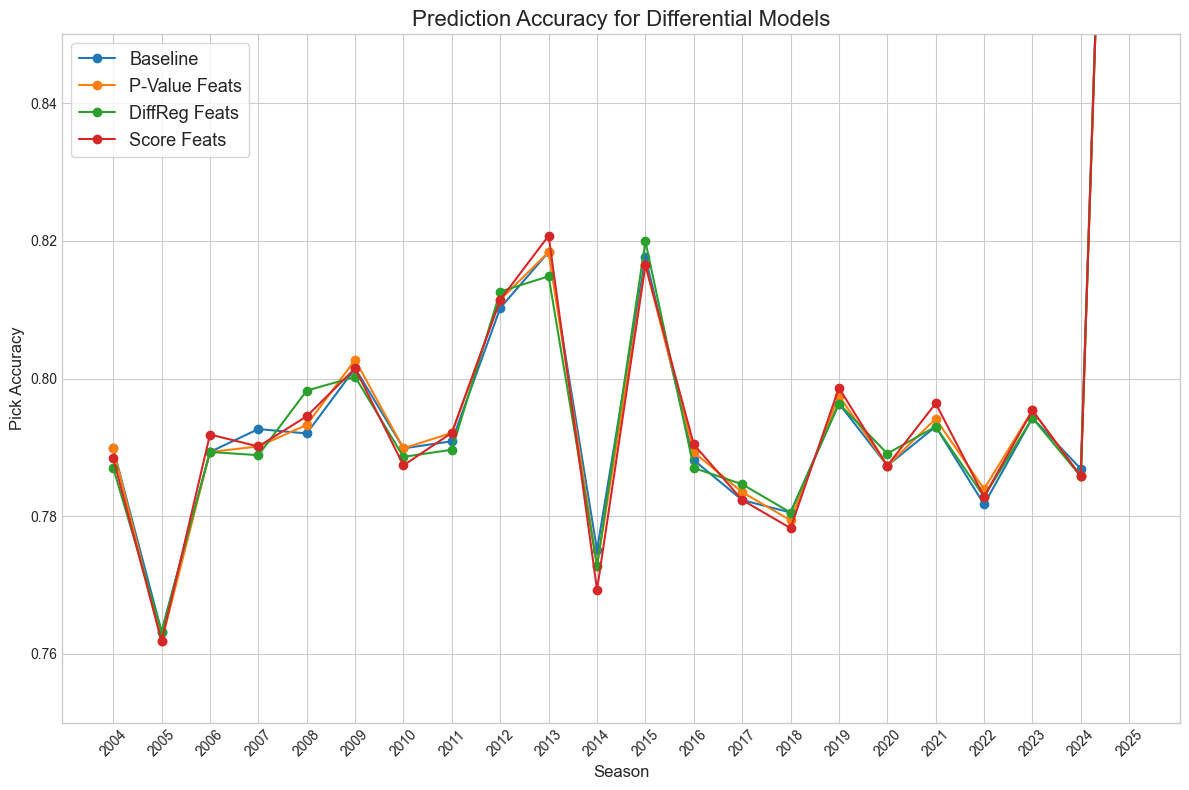

In [8]:
# --- Plotting the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

for model_name in results_df.columns:
    ax.plot(results_df.index, results_df[model_name], label=model_name, marker='o', linestyle='-')

ax.set_title('Prediction Accuracy for Differential Models', fontsize=16)
ax.set_xlabel('Season', fontsize=12)
ax.set_ylabel('Pick Accuracy', fontsize=12)
ax.legend(fontsize=13, frameon=True, fancybox=True)
ax.set_ylim(0.75, 0.85)
ax.set_xticks(seasons_to_run) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()